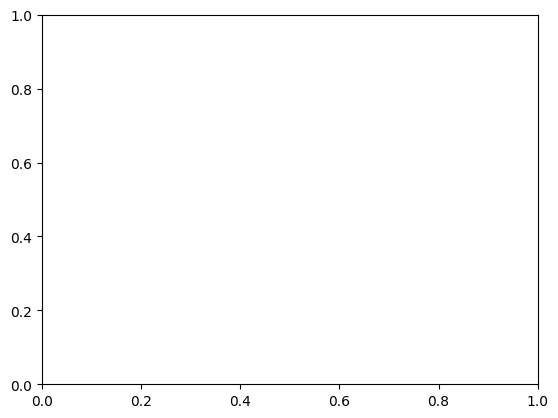

In [1]:
# %matplotlib widget

import pandas as pd
import warnings
from pandas import DataFrame
from scipy.signal import filtfilt, butter
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# plt.ion()
import matplotlib.ticker
import matplotlib.dates as mdates
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from parser_utils import folder_selection_utils
from scipy.stats import linregress
import os
import math
import parser_utils.parser_logger
import logging
import json
from parser_utils import folder_selection_utils
from torque_log_analysis import resample_data,drop_rows_from_df,lpf_df
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from motor import Motor

warnings.simplefilter(action='ignore',category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore',category=pd.errors.SettingWithCopyWarning)

plt.style.use('bmh')

# steps


- first, select folder for logs of car 1
- select folder for logs of car 2
- load logs, join
- set rpm to index
- join them all
- keep rows where torque is max for given rpm

In [2]:

# car1folder = folder_selection_utils.select_folder_and_get_path()
# car2folder = folder_selection_utils.select_folder_and_get_path()
car1folder = r'C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data'
car2folder = r'C:/Users/Matthew Samson/Documents/formula/228hv/parsed-data'
# car3folder = r'C:\Users\Matthew Samson\Documents\formula\6_19_23 ECAR COMP\parsed-data\enduranceOnly'
folders = [car1folder,car2folder]
print(f"Car 1 : '{car1folder}'\nCar 2: '{car2folder}'")

Car 1 : 'C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data'
Car 2: 'C:/Users/Matthew Samson/Documents/formula/228hv/parsed-data'


In [3]:
car_log_cols_to_keep = [
    "Time", "D1_Commanded_Torque", "D2_Torque_Feedback", "D2_Motor_Speed","D4_Iq", "D3_Id",'D2_Output_Voltage','D1_DC_Bus_Voltage']

df_list = []
for folder in folders:
    folder_dfs = []
    for filename in os.listdir(folder):
        # print(f"Folder: {folder}")
        if filename.endswith('.csv') or filename.endswith('.CSV'):
            print(f"Filename: {filename}")
            file_path = os.path.join(folder, filename)
            try:
                df = pd.read_csv(file_path)
                if df["D2_Motor_Speed"].max() < 1000:
                    print(f"Skipping {file_path} because motor speed less than 1000 max")
                    continue

                df = df[car_log_cols_to_keep]
                # for col in list(df):
                #     print(f"Old df col:{col} Max: {df[col].max()}")
                df = resample_data(df, "Time")
                df = drop_rows_from_df(df,"D1_Commanded_Torque",30,400)


                df = drop_rows_from_df(df, "D2_Motor_Speed", 200, 7000)
                df = lpf_df(df,10)
                df['filtD2_Motor_Speed'] = df['filtD2_Motor_Speed']/10
                df['filtD2_Motor_Speed'] = df['filtD2_Motor_Speed'].round(decimals=0)
                df['filtD2_Motor_Speed'] = df['filtD2_Motor_Speed']*10
                idx = df.groupby('filtD2_Motor_Speed')['filtD2_Torque_Feedback'].idxmax()
                filtdf = df.loc[idx]
                filtdf = df
                filtdf["motor_current"] = (filtdf["filtD4_Iq"] ** 2 + filtdf["filtD3_Id"] ** 2).pow(1/2)
                # create "160nm" throttle column

                filtdf['208_treq'] = df['filtD1_Commanded_Torque']/240 * 160
                
                # for col in list(filtdf):
                #     print(f"New df col:{col} Max: {filtdf[col].max()}")
                # df.set_index('filtD2_Motor_Speed',inplace=True)
                folder_dfs.append(filtdf)
                print("mader it here")
            except:
                print(f"Error with {file_path}")
    print(folder_dfs)
    if len(folder_dfs) > 0:
        folder_df = pd.concat(folder_dfs)
    df_list.append(folder_df)
car1df = df_list[0]
car2df = df_list[1]
# car3df = df_list[2]



Filename: parseddata0000.CSV


2024-03-26 16:16:05,844 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 55934 rows
2024-03-26 16:16:05,851 [INFO] torque_log_analysis.py:45: D2_Motor_Speed: dropped 109 rows


10Hz
mader it here
Filename: parseddata0001.CSV


2024-03-26 16:16:08,818 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 341655 rows
2024-03-26 16:16:08,825 [INFO] torque_log_analysis.py:45: D2_Motor_Speed: dropped 0 rows


10Hz
Error with C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0001.CSV
Filename: parseddata0002.CSV
Skipping C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0002.CSV because motor speed less than 1000 max
Filename: parseddata0003.CSV


2024-03-26 16:16:09,391 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 42617 rows
2024-03-26 16:16:09,396 [INFO] torque_log_analysis.py:45: D2_Motor_Speed: dropped 11 rows


10Hz
mader it here
Filename: parseddata0004.CSV
Skipping C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0004.CSV because motor speed less than 1000 max
Filename: parseddata0005.CSV


2024-03-26 16:16:11,755 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 189627 rows
2024-03-26 16:16:11,760 [INFO] torque_log_analysis.py:45: D2_Motor_Speed: dropped 101 rows


10Hz
mader it here
Filename: parseddata0006.CSV
Skipping C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0006.CSV because motor speed less than 1000 max
Filename: parseddata0007.CSV
Skipping C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0007.CSV because motor speed less than 1000 max
Filename: parseddata0008.CSV


2024-03-26 16:16:12,081 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 14966 rows
2024-03-26 16:16:12,085 [INFO] torque_log_analysis.py:45: D2_Motor_Speed: dropped 0 rows


10Hz
Error with C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0008.CSV
Filename: parseddata0009.CSV
Skipping C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0009.CSV because motor speed less than 1000 max
Filename: parseddata0010.CSV
Skipping C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0010.CSV because motor speed less than 1000 max
Filename: parseddata0011.CSV
Skipping C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0011.CSV because motor speed less than 1000 max
Filename: parseddata0012.CSV


2024-03-26 16:16:15,086 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 210064 rows
2024-03-26 16:16:15,093 [INFO] torque_log_analysis.py:45: D2_Motor_Speed: dropped 289 rows


10Hz
mader it here
Filename: parseddata0013.CSV
Skipping C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0013.CSV because motor speed less than 1000 max
Filename: parseddata0014.CSV


2024-03-26 16:16:20,774 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 429817 rows
2024-03-26 16:16:20,783 [INFO] torque_log_analysis.py:45: D2_Motor_Speed: dropped 719 rows


10Hz
mader it here
Filename: parseddata0015.CSV


2024-03-26 16:16:21,463 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 37203 rows
2024-03-26 16:16:21,469 [INFO] torque_log_analysis.py:45: D2_Motor_Speed: dropped 218 rows


10Hz
mader it here
Filename: parseddata0016.CSV
Skipping C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0016.CSV because motor speed less than 1000 max
[                         D1_Commanded_Torque  D2_Torque_Feedback  \
Time                                                               
2023-04-26 16:17:05.730            34.430435            1.808696   
2023-04-26 16:17:05.740            34.360870            4.417391   
2023-04-26 16:17:05.750            34.326087            5.721739   
2023-04-26 16:17:05.760            34.326087            5.721739   
2023-04-26 16:17:05.770            34.326087            5.721739   
...                                      ...                 ...   
2023-04-26 16:23:49.540            36.881250           33.806250   
2023-04-26 16:23:49.550            36.881250           33.806250   
2023-04-26 16:23:49.560            36.881250           33.806250   
2023-04-26 16:23:49.570            36.881250           33

2024-03-26 16:16:25,880 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 19493 rows
2024-03-26 16:16:25,883 [INFO] torque_log_analysis.py:45: D2_Motor_Speed: dropped 95 rows


10Hz
mader it here
Filename: parsedMDY_3-3-2024_HMS_4-11-35.CSV


2024-03-26 16:16:27,814 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 14875 rows
2024-03-26 16:16:27,819 [INFO] torque_log_analysis.py:45: D2_Motor_Speed: dropped 62 rows


10Hz
mader it here
[                         D1_Commanded_Torque  D2_Torque_Feedback  \
Time                                                               
2024-03-03 04:00:37.970            39.500000           39.433333   
2024-03-03 04:00:37.980            39.500000           39.820000   
2024-03-03 04:00:37.990            39.500000           39.560000   
2024-03-03 04:00:38.000            39.500000           38.100000   
2024-03-03 04:00:38.010            39.500000           38.140000   
...                                      ...                 ...   
2024-03-03 04:01:09.970           108.800000           -3.140000   
2024-03-03 04:01:09.980           100.633333           11.533333   
2024-03-03 04:01:09.990            76.266667            7.600000   
2024-03-03 04:01:10.000            51.280000            2.840000   
2024-03-03 04:01:10.010            37.900000           -1.900000   

                         D2_Motor_Speed      D4_Iq       D3_Id  \
Time                         

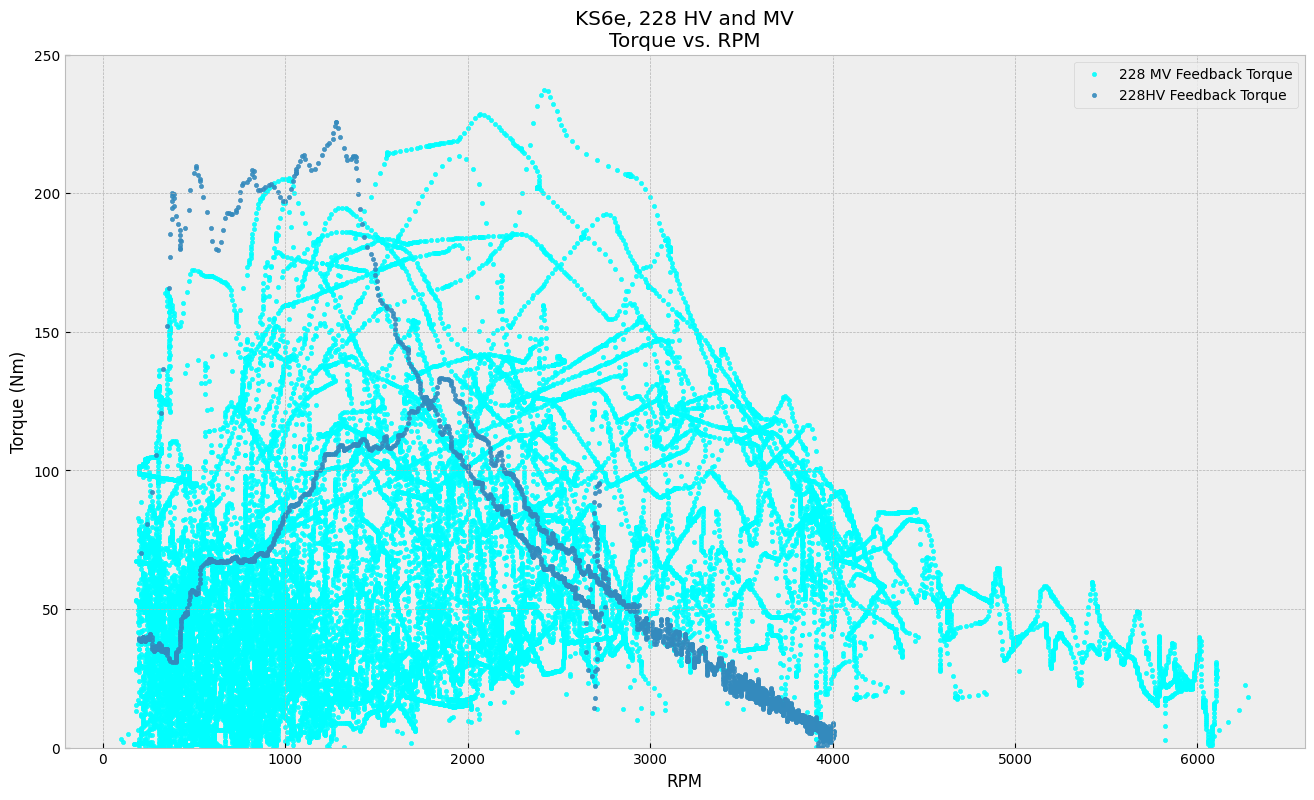

In [4]:
fig, ax = plt.subplots(figsize=(16,9))
# ax.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD1_Commanded_Torque'],
#                 marker='.', label="Car 1Command Torque", c='blue', alpha=0.9)
ax.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD2_Torque_Feedback'],
                marker='.', label="228 MV Feedback Torque", c='aqua', alpha=0.9)
# ax.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD2_Output_Voltage'],
#                 marker='.', label="228 MV Iq", alpha=0.5)
# ax.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD1_Commanded_Torque'],
#                 marker='.', label="Car 2Command Torque", alpha=0.9)
ax.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD2_Torque_Feedback'],
                marker='.', label="228HV Feedback Torque", alpha=0.9)
# ax.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD2_Output_Voltage'],
#                 marker='.', label="228 HV Iq",  alpha=0.5)
plt.title("KS6e, 228 HV and MV\nTorque vs. RPM")
ax.grid(visible=True)
plt.ylim((0,250))
plt.xlabel("RPM")
plt.ylabel("Torque (Nm)")
plt.legend()
plt.show()

In [5]:
emrax228mv = Motor('228MV')
emrax228mv.Ld = 0.000096
emrax228mv.Lq = 0.000099
emrax228mv.Rs = 0.0076 #0.0071
emrax228mv.max_phase_current = 360.0 * math.sqrt(2)
emrax228mv.max_rate = 6500.0
emrax228mv.Fl = 0.03737
emrax228mv.poles = 10.0
emrax228mv.I_dmax = 221 # A
emrax228mv.I_qmax = 453 # A

emrax228hv = Motor('228HV')
emrax228hv.Ld = 0.000225
emrax228hv.Lq = 0.000230
emrax228hv.Rs = 0.01548 #0.0071
emrax228hv.max_phase_current = 235.0 * math.sqrt(2)
emrax228hv.max_rate = 6500.0
emrax228hv.Fl = 0.05728
emrax228hv.poles = 10.0
emrax228hv.I_dmax = 150 # A
emrax228hv.I_qmax = 339 # A
current_lims = 600
torque = 240
speed = 6000.0
voltage = 300

# Emrax 208HV and MV defs
emrax208hv = Motor('208HV')
emrax208hv.Ld = 0.0001755
emrax208hv.Lq = 0.0001760 #  guess
emrax208hv.Rs = (12.27)/1000 #milliohms
emrax208hv.max_phase_current = 240 * math.sqrt(2)
emrax208hv.max_rate = 7000
emrax208hv.Fl = 0.03758
emrax208hv.poles = 10
emrax208hv.I_dmax = 150 # From cascadia setup
emrax208hv.I_qmax = 283 # From cascadia setup

emrax208mv = Motor('208MV')
emrax208mv.Ld = 0.0000735
emrax208mv.Lq = 0.0000750 #  guess
emrax208mv.Rs = (5.51)/1000 #milliohms
emrax208mv.max_phase_current = 400 * math.sqrt(2)
emrax208mv.max_rate = 7000
emrax208mv.Fl = 0.02338
emrax208mv.poles = 10
emrax208mv.I_dmax = 425 # From cascadia setup, probably wrong
emrax208mv.I_qmax = 425 # From cascadia setup

motors = [emrax228mv,emrax228hv,emrax208mv,emrax208hv]


In [6]:

fig = go.Figure()

def calc_current_limit(current, points):
    angles = np.linspace(0, 2*np.pi, points)
    i_d = current * np.cos(angles)
    i_q = current * np.sin(angles)
    return i_d, i_q

def create_rectangle(iq_lim, id_lim):
    # create all the points needed to make a rectangle with the limits of the motor controller
    i_q, i_d = np.zeros(5), np.zeros(5)
    i_q[[0, 1, 4]] = iq_lim
    i_q[[2, 3]] = -iq_lim
    i_d[[0, 3, 4]] = id_lim
    i_d[[1, 2]] = -id_lim
    return i_d, i_q
i_dmtpa, i_qmtpa = emrax228mv.calc_mtpa(np.linspace(0, 2 * emrax228mv.i_max, 1000))
fig.add_trace(go.Scatter(x=i_dmtpa, y=i_qmtpa, mode='lines', name='MTPA', line=dict(color='green', width=2)))
i_d_torque = np.linspace(-current_lims, current_lims, 1000)
i_q_torque = emrax228mv.calc_iq(torque, i_d_torque)
fig.add_trace(go.Scatter(x=i_d_torque, y=i_q_torque, mode='lines', name='Requested Torque Curve', line=dict(color='blue', width=2)))
i_d_emf, i_q_emf = emrax228mv.calc_emf_limit(speed, voltage, 1000)
fig.add_trace(go.Scatter(x=i_d_emf, y=i_q_emf, mode='lines', name='EMF Circle', line=dict(color='white', width=2)))
i_d_winding, i_q_winding = emrax228mv.calc_current_limit(1000)
fig.add_trace(go.Scatter(x=i_d_winding, y=i_q_winding, mode='lines', name='Current Limit', line=dict(color='red', width=2)))
i_d_eeprom, i_q_eeprom = create_rectangle(453, 221)
fig.add_trace(go.Scatter(x=i_d_eeprom, y=i_q_eeprom, mode='lines', name='MCU EEPROM Current Limit', line=dict(color='orange', width=2)))
i_d_gate, i_q_gate = calc_current_limit(380, 1000)
fig.add_trace(go.Scatter(x=i_d_gate, y=i_q_gate, mode='lines', name='MCU Gate Current Limit', line=dict(color='purple', width=2)))
fig.update_layout(template="plotly_dark", title_text=f"Iq and Id Current Target", height=1000, width=1000, xaxis_title="i_d", yaxis_title="i_q", xaxis_range=[-current_lims, current_lims], yaxis_range=[-current_lims, current_lims])
fig.show()

In [7]:
# Create a DataFrame with 3 columns
df = pd.DataFrame()

# First column: Go from zero to 6000 in increments of 10
df['w'] = range(0, 6001, 10)

# Second column: Fixed at 240 for every row
df['t'] = 240

# Third column: Fixed at 190 for every row
df['v'] = 190

print(df)
emrax228mv = Motor('Emrax 228 MV')
df['id_t'] = np.zeros(len(df))
df['iq_t'] = np.zeros(len(df))
df['t_t'] = np.zeros(len(df))
df['w_t'] = np.zeros(len(df))
df['v_max'] = np.zeros(len(df))
def calcc(w, t, v):
    Id, Iq, T, wbase, v_max = emrax228mv.get_qd_currents(w, t, v)
    return Id, Iq, T, wbase * 60 / (2 * np.pi), v_max
for i in range(len(df)):
    df['id_t'][i], df['iq_t'][i], df['t_t'][i], df['w_t'][i], df['v_max'][i] = calcc(df['w'][i], df['t'][i], df['v'][i])



        w    t    v
0       0  240  190
1      10  240  190
2      20  240  190
3      30  240  190
4      40  240  190
..    ...  ...  ...
596  5960  240  190
597  5970  240  190
598  5980  240  190
599  5990  240  190
600  6000  240  190

[601 rows x 3 columns]


c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:82: RuntimeWarning:

divide by zero encountered in scalar divide



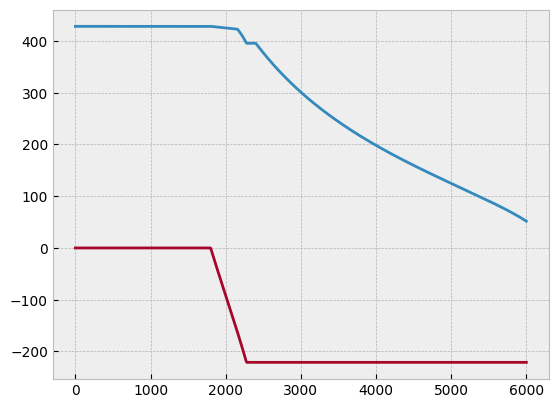

In [8]:
plt.plot(df['w'],df['iq_t'])
plt.plot(df['w'],df['id_t'])
plt.show()


In [9]:
cur_motor = emrax228hv
def calcc(motor:Motor,w, t, v):
    Id, Iq, T, wbase, v_max = motor.get_qd_currents(w, t, v)
    return Id, Iq, T, wbase * 60 / (2 * np.pi), v_max
car2df['id_t'] = np.zeros(len(car2df))
car2df['iq_t'] = np.zeros(len(car2df))
car2df['t_t'] = np.zeros(len(car2df))
car2df['w_t'] = np.zeros(len(car2df))
car2df['v_max'] = np.zeros(len(car2df))
car2df['240nm'] = np.full(len(car2df),240)
car2df['160nm'] = np.full(len(car2df),160)
car2df['300v'] = np.full(len(car2df),250)

# plot the commanded torque vs actual vs calculated theoretical
for i in range(len(car2df)):
    car2df['id_t'][i], car2df['iq_t'][i], car2df['t_t'][i], car2df['w_t'][i], car2df['v_max'][i] = calcc(emrax228hv,car2df['filtD2_Motor_Speed'][i], car2df['filtD1_Commanded_Torque'][i], car2df['filtD1_DC_Bus_Voltage'][i])
car2df['theoretical_motorcurrent'] = (car2df['id_t']**2 +  car2df['iq_t']**2).pow(1/2)

cur_motor = emrax228mv
car1df['id_t'] = np.zeros(len(car1df))
car1df['iq_t'] = np.zeros(len(car1df))
car1df['t_t'] = np.zeros(len(car1df))
car1df['w_t'] = np.zeros(len(car1df))
car1df['v_max'] = np.zeros(len(car1df))
car1df['240nm'] = np.full(len(car1df),240)
car1df['160nm'] = np.full(len(car1df),160)

car1df['300v'] = np.full(len(car1df),250)

# plot the commanded torque vs actual vs calculated theoretical
for i in range(len(car1df)):
    car1df['id_t'][i], car1df['iq_t'][i], car1df['t_t'][i], car1df['w_t'][i], car1df['v_max'][i] = calcc(emrax228mv,car1df['filtD2_Motor_Speed'][i], car1df['filtD1_Commanded_Torque'][i], car1df['filtD1_DC_Bus_Voltage'][i])
car1df['theoretical_motorcurrent'] = (car1df['id_t']**2 +  car1df['iq_t']**2).pow(1/2)


c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew

In [10]:
# arg order: [rpm,torque,voltage]
def add_motor_data_to_df(motor:Motor,df:DataFrame,args:list)->DataFrame:
    newcols = ['id_t','iq_t','t_t','w_t','v_max']
    for col in newcols:
        df[motor.name+col]=np.zeros(len(df))
    for i in range(len(df)):
        df[motor.name+'id_t'][i], df[motor.name+'iq_t'][i], df[motor.name+'t_t'][i], df[motor.name+'w_t'][i], df[motor.name+'v_max'][i] = calcc(motor,df[args[0]][i], df[args[1]][i], df[args[2]][i])


In [11]:
for df in df_list:
    # fig = plt.subplots((len(motors)),1,figsize=(16,9))
    # axes=plt.gcf().get_axes()

    for index,motor in enumerate(motors):
        if motor.max_rate < 6600:
            torque_col = 'filtD1_Commanded_Torque'
        else: 
            torque_col = '208_treq'
        print("starting")
        add_motor_data_to_df(motor,df,['filtD2_Motor_Speed',torque_col,'filtD1_DC_Bus_Voltage'])
        
        # axes[index].scatter(df['filtD2_Motor_Speed'], df[torque_col],
        #             marker='o', label="Torque Command", c='blue')
        # axes[index].scatter(df['filtD2_Motor_Speed'], df[motor.name+'t_t'],
        #             marker='.', label=motor.name+"Torque Feedback")
        df[motor.name+"power"] = df[motor.name+'t_t'] * df['filtD2_Motor_Speed'] / 9548.8
    #     axes[index].scatter(df['filtD2_Motor_Speed'],df[motor.name+"power"],label=f'{motor.name} PowerkW',marker='.')
    #     axes[index].legend()
    #     axes[index].title.set_text(f"{motor.name} Theoretical Power vs RPM")
    #     axes[index].set_xlabel("RPM")
    #     axes[index].set_ylabel("Power (Kw)")
    # plt.tight_layout()

    

starting


c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew

starting


c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew Samson\source\repos\python-data-analysis\motor.py:88: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Matthew

starting
starting


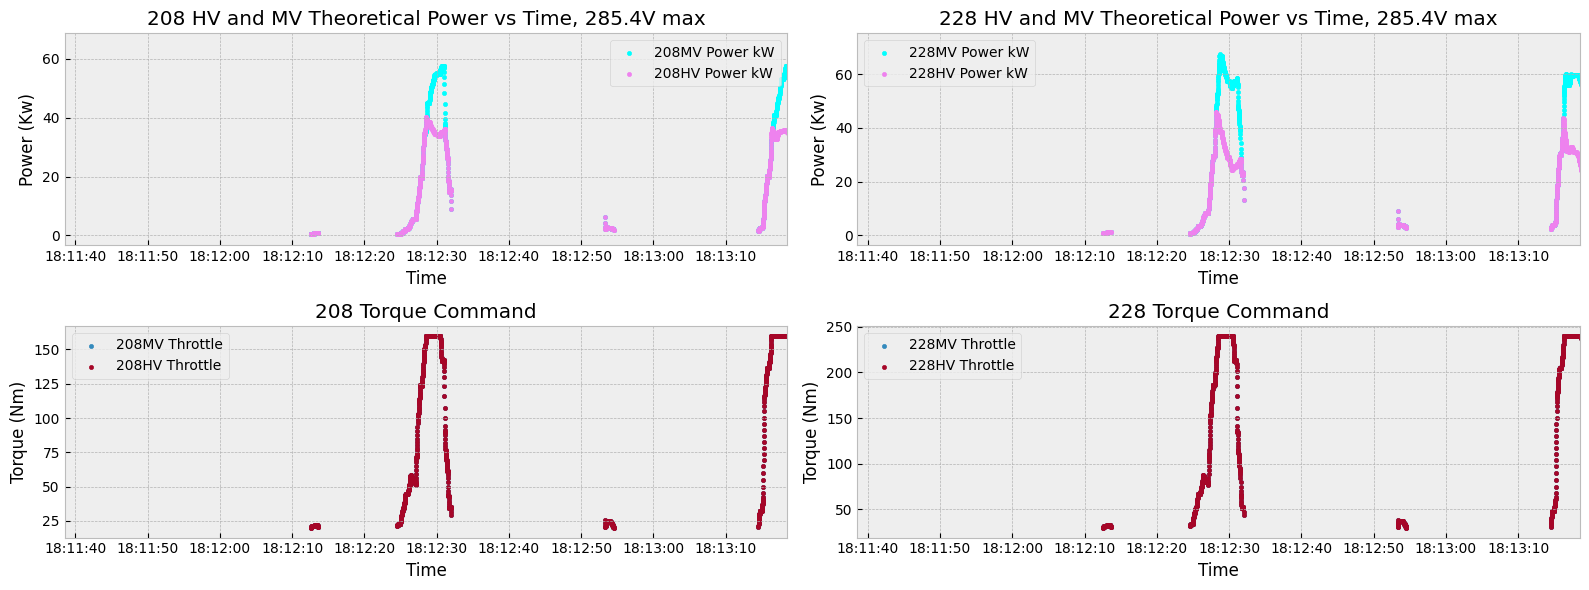

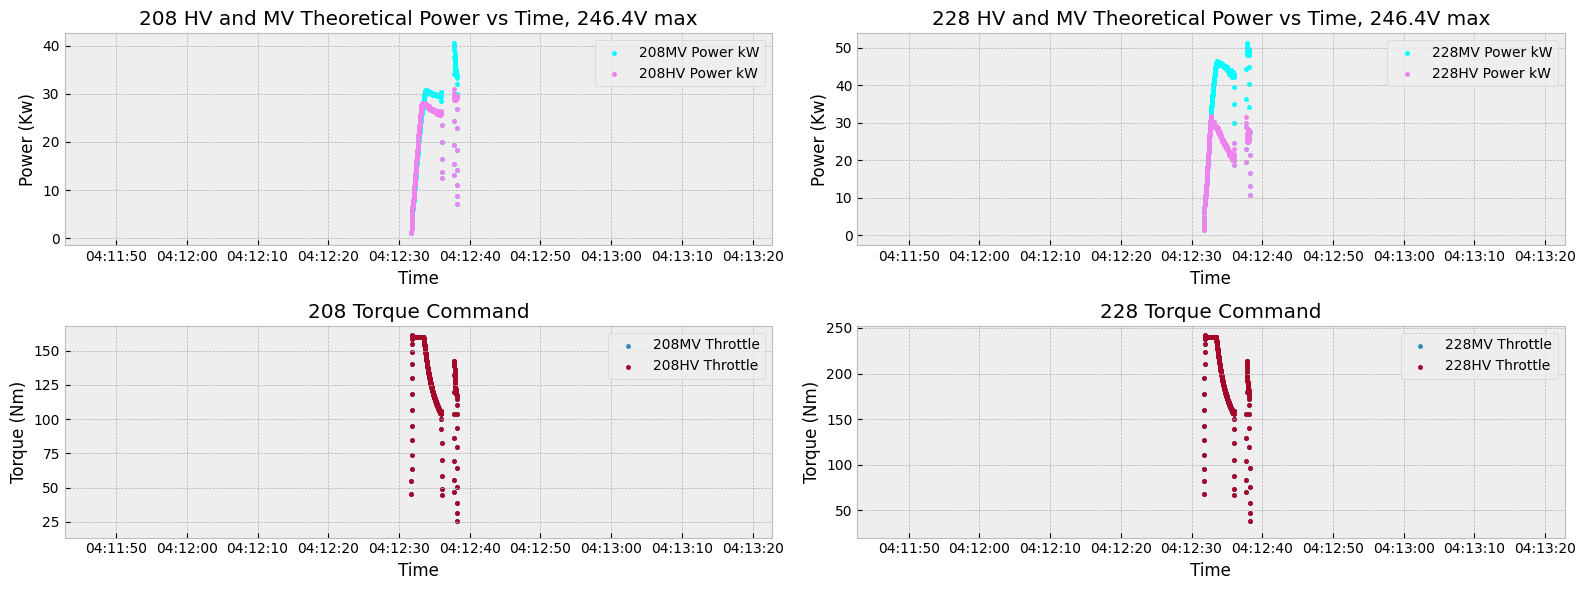

In [ ]:
motor_names = ['208','228']
colors = []
for df in df_list:
    runoffset = pd.tseries.offsets.DateOffset(seconds=50)
    centertime = df['filtD2_Torque_Feedback'].idxmax()
    xlims = (centertime-runoffset,centertime+runoffset)
    fig = plt.subplots((len(motor_names)),2,figsize=(16,6))
    axes=plt.gcf().get_axes()
    for index,motor in enumerate(motors):
        if motor.max_rate < 6600:
            torque_col = 'filtD1_Commanded_Torque'
        else: 
            torque_col = '208_treq'
        motor_index = 0 if '208' in motor.name else 1
        color = 'violet' if 'HV' in motor.name else 'cyan'
        axes[motor_index].scatter(df.index,df[motor.name+"power"],label=f'{motor.name} Power kW',marker='.',color=color)
        axes[motor_index+2].scatter(df.index,df[torque_col],label=f'{motor.name} Throttle',marker='.')
        axes[motor_index+2].legend()
        axes[motor_index].legend()
        axes[motor_index].title.set_text(f"{motor_names[motor_index]} HV and MV Theoretical Power vs Time, {df['filtD1_DC_Bus_Voltage'].max():.1f}V max")
        axes[motor_index+2].title.set_text(f"{motor_names[motor_index]} Torque Command")
        axes[motor_index+2].set_xlabel("Time")
        axes[motor_index+2].set_ylabel("Torque (Nm)")
        axes[motor_index].set_xlabel("Time")
        axes[motor_index].set_ylabel("Power (Kw)")
    for axis in axes:
        axis.set_xlim(xlims)
    plt.tight_layout()

In [ ]:
torque_vs_rpm_df = df_list[0][['filtD2_Motor_Speed','208MVt_t']]
torque_vs_rpm_df['filtD2_Motor_Speed'] = torque_vs_rpm_df['filtD2_Motor_Speed']/100
torque_vs_rpm_df['filtD2_Motor_Speed'] = torque_vs_rpm_df['filtD2_Motor_Speed'].round(decimals=0)
result = torque_vs_rpm_df.groupby('filtD2_Motor_Speed')['208MVt_t'].max()
result = result.reset_index()
result['filtD2_Motor_Speed'] =result['filtD2_Motor_Speed']*100

result.set_index('filtD2_Motor_Speed',inplace=True)

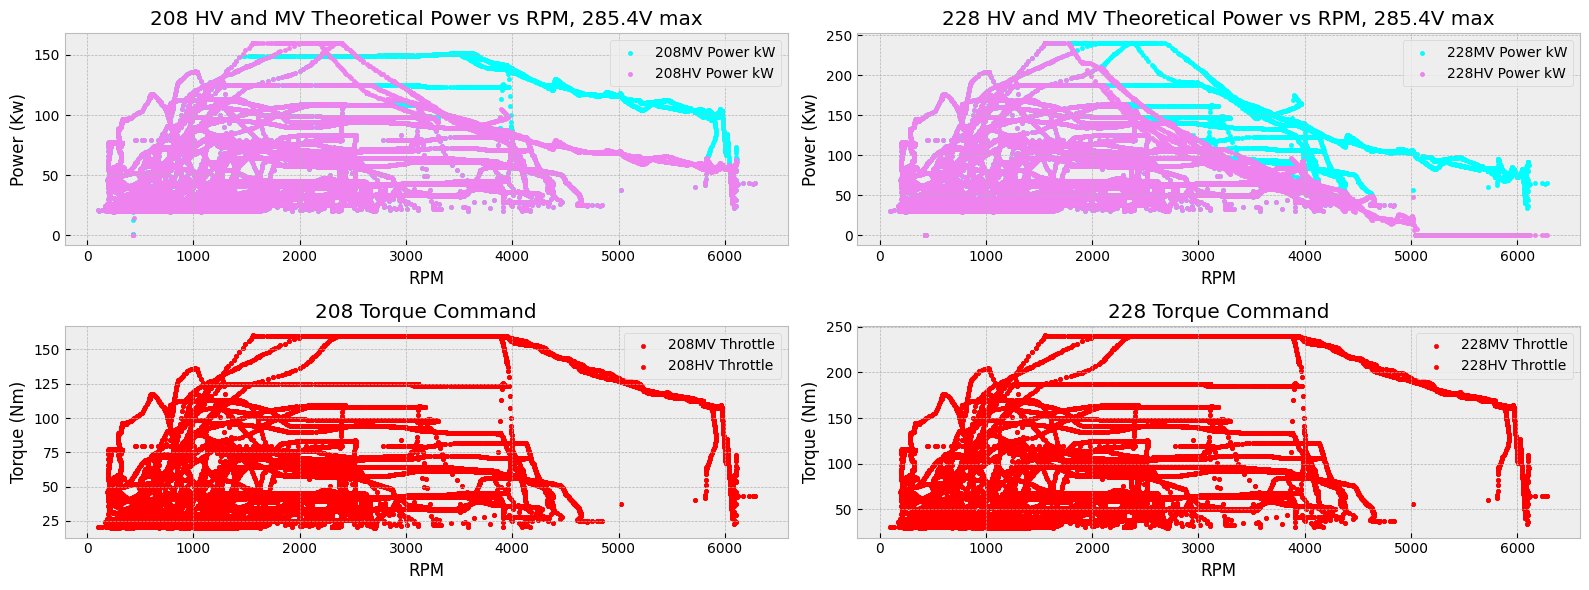

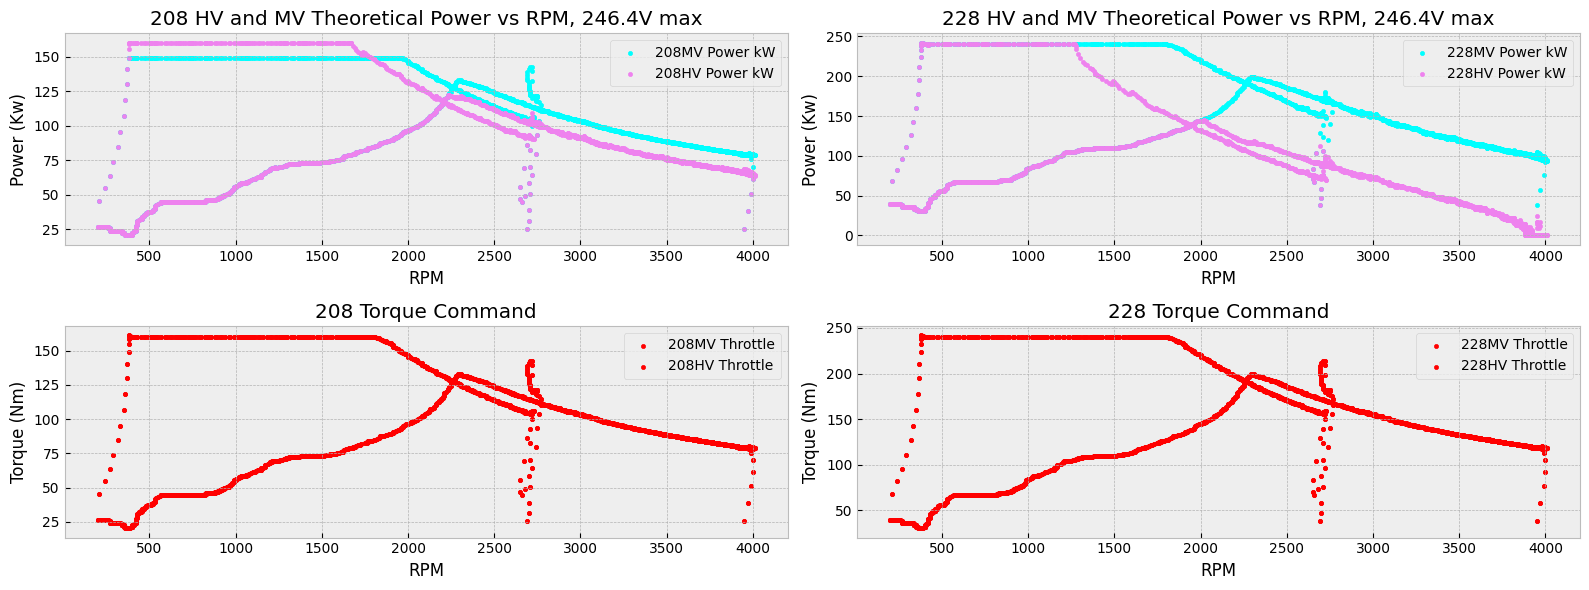

In [ ]:
motor_names = ['208','228']
colors = []
for df in df_list:
    fig = plt.subplots((len(motor_names)),2,figsize=(16,6))
    axes=plt.gcf().get_axes()
    for index,motor in enumerate(motors):
        if motor.max_rate < 6600:
            torque_col = 'filtD1_Commanded_Torque'
        else: 
            torque_col = '208_treq'
        motor_index = 0 if '208' in motor.name else 1
        color = 'violet' if 'HV' in motor.name else 'cyan'
        axes[motor_index].scatter(df['filtD2_Motor_Speed'],df[motor.name+"t_t"],label=f'{motor.name} Power kW',marker='.',color=color)
        axes[motor_index+2].scatter(df['filtD2_Motor_Speed'],df[torque_col],label=f'{motor.name} Throttle',marker='.',color='r')
        axes[motor_index+2].legend()
        axes[motor_index].legend()
        axes[motor_index].title.set_text(f"{motor_names[motor_index]} HV and MV Theoretical Power vs RPM, {df['filtD1_DC_Bus_Voltage'].max():.1f}V max")
        axes[motor_index+2].title.set_text(f"{motor_names[motor_index]} Torque Command")
        axes[motor_index+2].set_xlabel("RPM")
        axes[motor_index+2].set_ylabel("Torque (Nm)")
        axes[motor_index].set_xlabel("RPM")
        axes[motor_index].set_ylabel("Power (Kw)")
    plt.tight_layout()

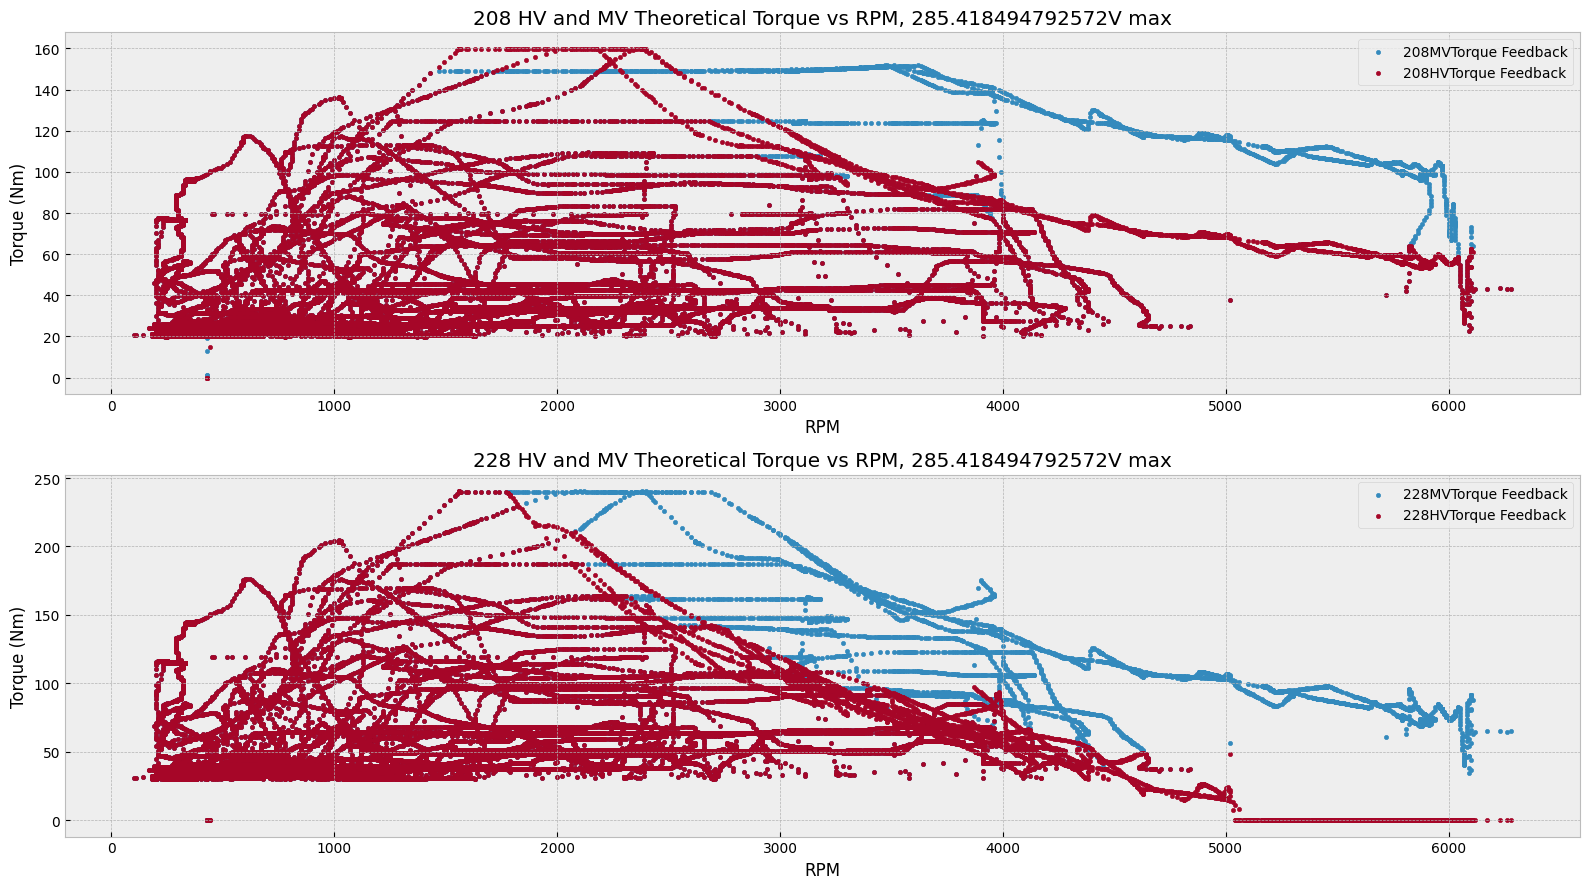

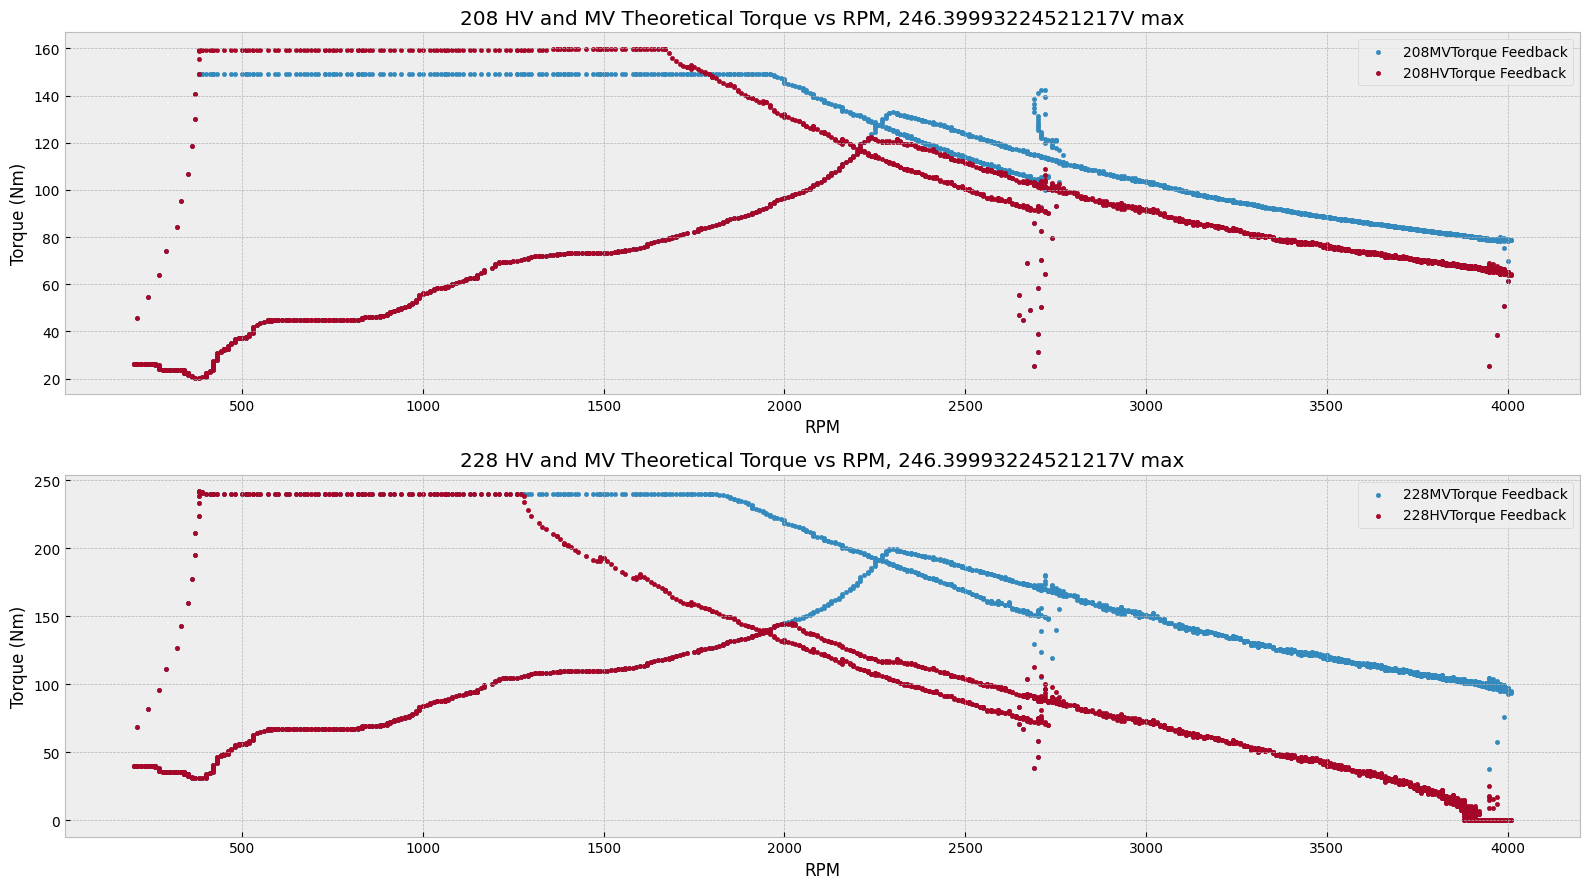

In [ ]:
motor_names=set()
motor_names = ['208','228']
for df in df_list:
    fig = plt.subplots((len(motor_names)),1,figsize=(16,9))
    axes=plt.gcf().get_axes()

    for index,motor in enumerate(motors):
        motor_index = 0 if '208' in motor.name else 1

        # axes[motor_index].scatter(df['filtD2_Motor_Speed'], df[torque_col],
        #             marker='o', label="Torque Command", c='blue')
        axes[motor_index].scatter(df['filtD2_Motor_Speed'], df[motor.name+'t_t'],
                    marker='.', label=motor.name+"Torque Feedback")
        df[motor.name+"power"] = df[motor.name+'t_t'] * df['filtD2_Motor_Speed'] / 9548.8
        # axes[motor_index].scatter(df['filtD2_Motor_Speed'],df[motor.name+"power"],label=f'{motor.name} PowerkW',marker='.')
        axes[motor_index].legend()
        axes[motor_index].title.set_text(f"{motor_names[motor_index]} HV and MV Theoretical Torque vs RPM, {df['filtD1_DC_Bus_Voltage'].max()}V max")
        axes[motor_index].set_xlabel("RPM")
        axes[motor_index].set_ylabel("Torque (Nm)")
    plt.tight_layout()

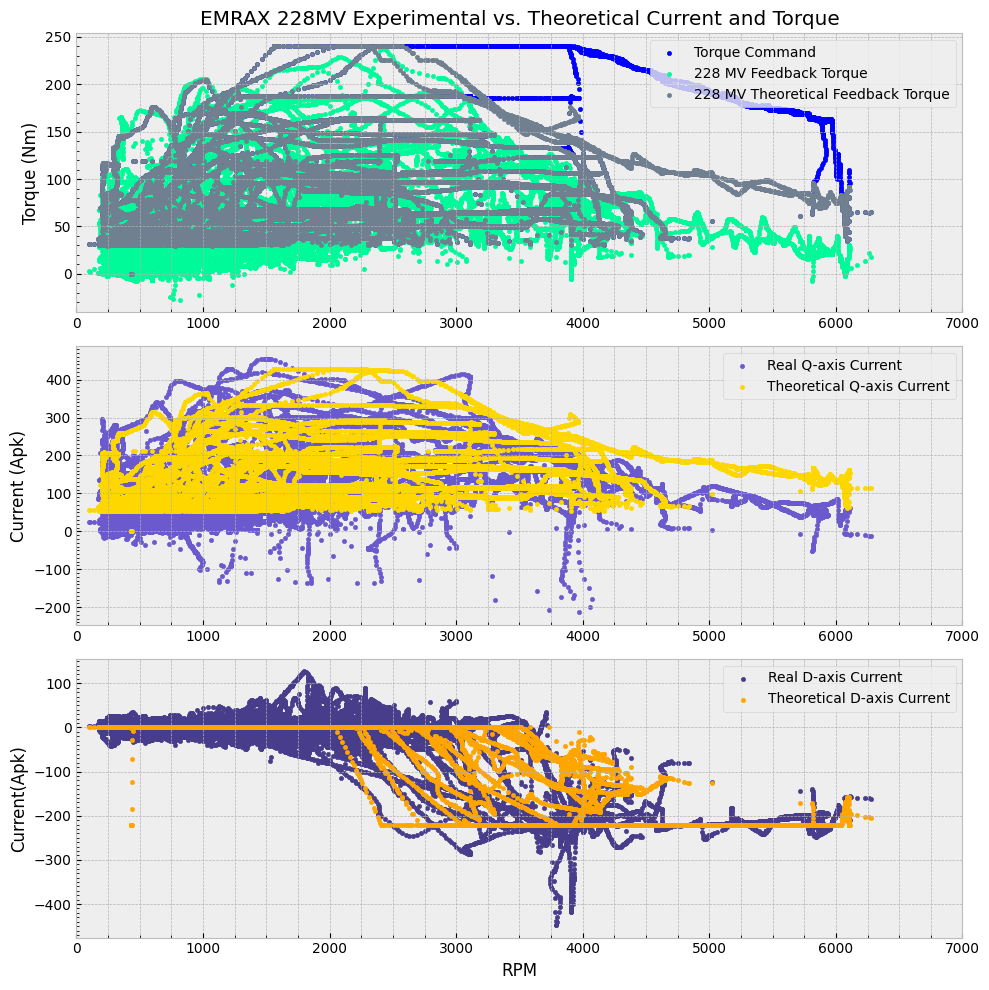

In [ ]:

fig,(ax,ax1,ax2) = plt.subplots(3,1,figsize=(10,10))
ax.title.set_text("EMRAX 228MV Experimental vs. Theoretical Current and Torque")


runoffset = pd.tseries.offsets.DateOffset(seconds=30)
centertime = car1df['filtD2_Torque_Feedback'].idxmax()
# Torque command
ax.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD1_Commanded_Torque'],
                marker='.', label="Torque Command", c='blue')
#Real torque feedback``
ax.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD2_Torque_Feedback'],
                marker='.', label="228 MV Feedback Torque", c='mediumspringgreen')

ax.scatter(car1df['filtD2_Motor_Speed'], car1df['t_t'],
                marker='.', label="228 MV Theoretical Feedback Torque",c='slategrey')
# Real Q-axis current
ax1.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD4_Iq'],
                marker='.', label="Real Q-axis Current",c='slateblue')

ax1.scatter(car1df['filtD2_Motor_Speed'], car1df['iq_t'],
                marker='.', label="Theoretical Q-axis Current",color='gold')

ax2.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD3_Id'],
                marker='.', label="Real D-axis Current",c='darkslateblue')
# plt.xlim(xlims)

ax2.scatter(car1df['filtD2_Motor_Speed'], car1df['id_t'],
                marker='.', label="Theoretical D-axis Current",color='orange')
ylabels = ["Torque (Nm)","Current (Apk)","Current(Apk)"]
for index,axis in enumerate(plt.gcf().get_axes()):
    axis.legend()
    axis.grid(visible=True)
    axis.set_ylabel(ylabels[index])
    axis.xaxis.set_minor_locator(MultipleLocator(250))
    axis.yaxis.set_minor_locator(MultipleLocator(10))
    axis.xaxis.grid(True,which="minor")

    # axis.set_ylim((0,250))
    axis.set_xlim((0,7000))
    
ax2.set_xlabel("RPM")
plt.tight_layout()

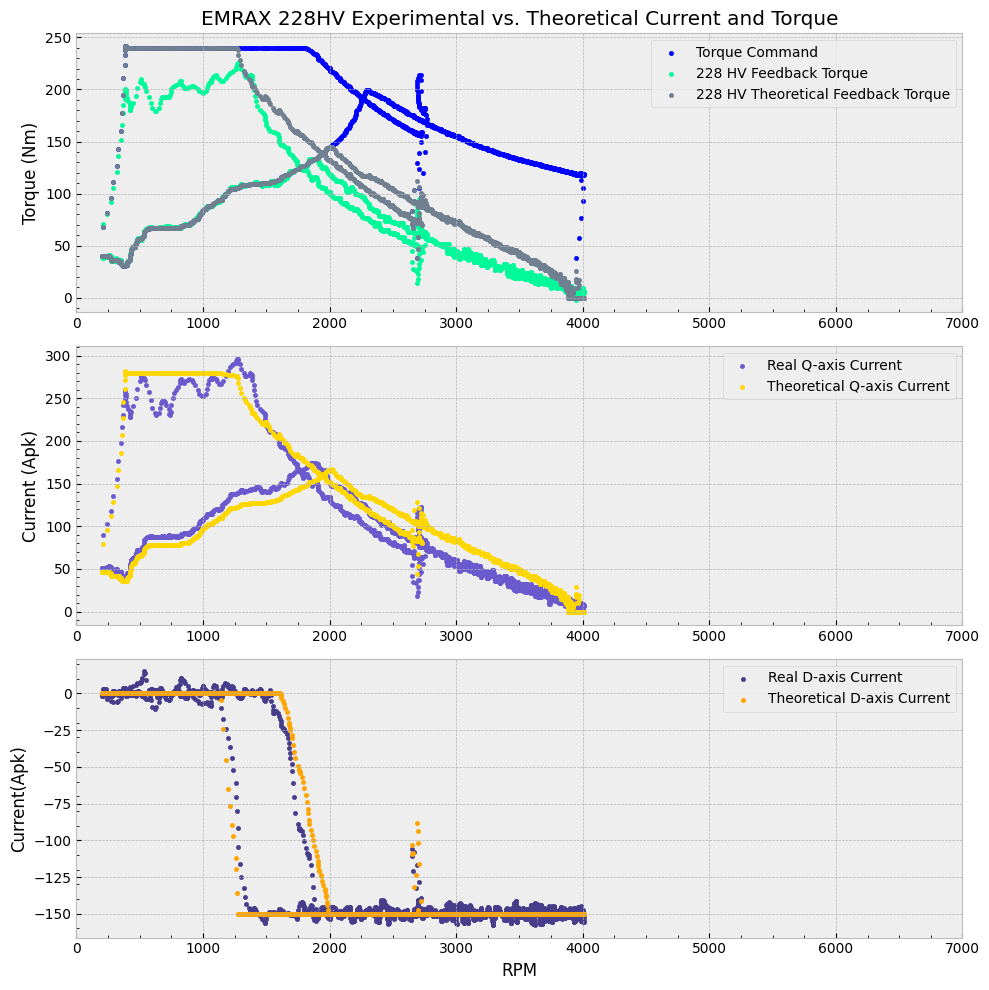

In [ ]:

fig,(ax,ax1,ax2) = plt.subplots(3,1,figsize=(10,10))
ax.title.set_text("EMRAX 228HV Experimental vs. Theoretical Current and Torque")


runoffset = pd.tseries.offsets.DateOffset(seconds=30)
centertime = car2df['filtD2_Torque_Feedback'].idxmax()
# Torque command
ax.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD1_Commanded_Torque'],
                marker='.', label="Torque Command", c='blue')
#Real torque feedback``
ax.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD2_Torque_Feedback'],
                marker='.', label="228 HV Feedback Torque", c='mediumspringgreen')

ax.scatter(car2df['filtD2_Motor_Speed'], car2df['t_t'],
                marker='.', label="228 HV Theoretical Feedback Torque",c='slategrey')
# Real Q-axis current
ax1.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD4_Iq'],
                marker='.', label="Real Q-axis Current",c='slateblue')

ax1.scatter(car2df['filtD2_Motor_Speed'], car2df['iq_t'],
                marker='.', label="Theoretical Q-axis Current",color='gold')

ax2.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD3_Id'],
                marker='.', label="Real D-axis Current",c='darkslateblue')
# plt.xlim(xlims)

ax2.scatter(car2df['filtD2_Motor_Speed'], car2df['id_t'],
                marker='.', label="Theoretical D-axis Current",color='orange')
ylabels = ["Torque (Nm)","Current (Apk)","Current(Apk)"]
for index,axis in enumerate(plt.gcf().get_axes()):
    axis.legend()
    axis.grid(visible=True)
    axis.set_ylabel(ylabels[index])
    axis.xaxis.set_minor_locator(MultipleLocator(250))
    axis.yaxis.set_minor_locator(MultipleLocator(10))

    # axis.set_ylim((0,250))
    axis.set_xlim((0,7000))
    
ax2.set_xlabel("RPM")
plt.tight_layout()

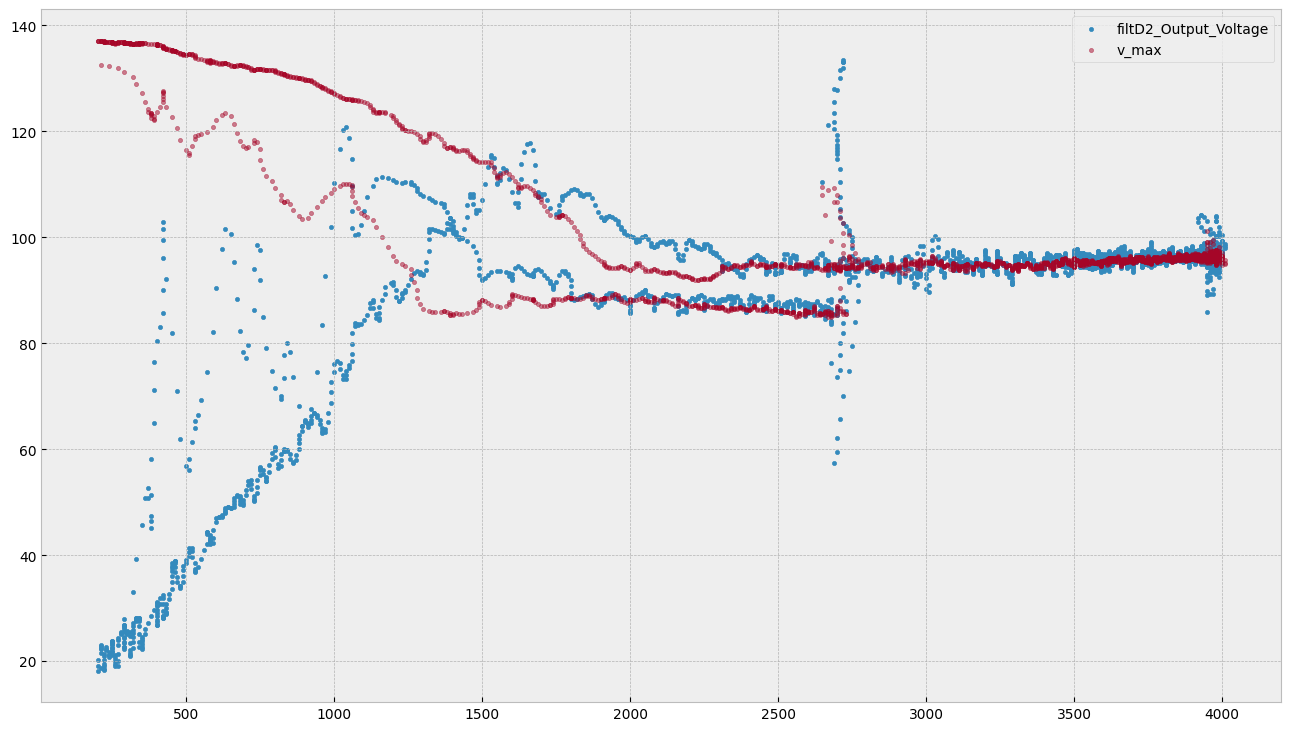

In [ ]:
# Compare calculated vmax vs output voltage
fig, ax= plt.subplots(figsize=(16,9))
ax.scatter(car2df['filtD2_Motor_Speed'],car2df['filtD2_Output_Voltage'],label='filtD2_Output_Voltage',marker='.')
ax.scatter(car2df['filtD2_Motor_Speed'],car2df['v_max'],label='v_max',alpha=.5,marker='.')
plt.legend()
def annot_cols(df:DataFrame,cols:list,ax,unit:str,timeindex=None):
    for col in cols:
        xmax = (df[col].idxmax())
        if timeindex:
            xmax = df[timeindex][xmax]
        ymax = df[col].max()
        ax.annotate(
            f"{col} max: {ymax:.2f}{unit}",
            xy=(xmax, ymax), xycoords='data',
            xytext=(-300, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle='->',linewidth=1.2,color='black'))
      


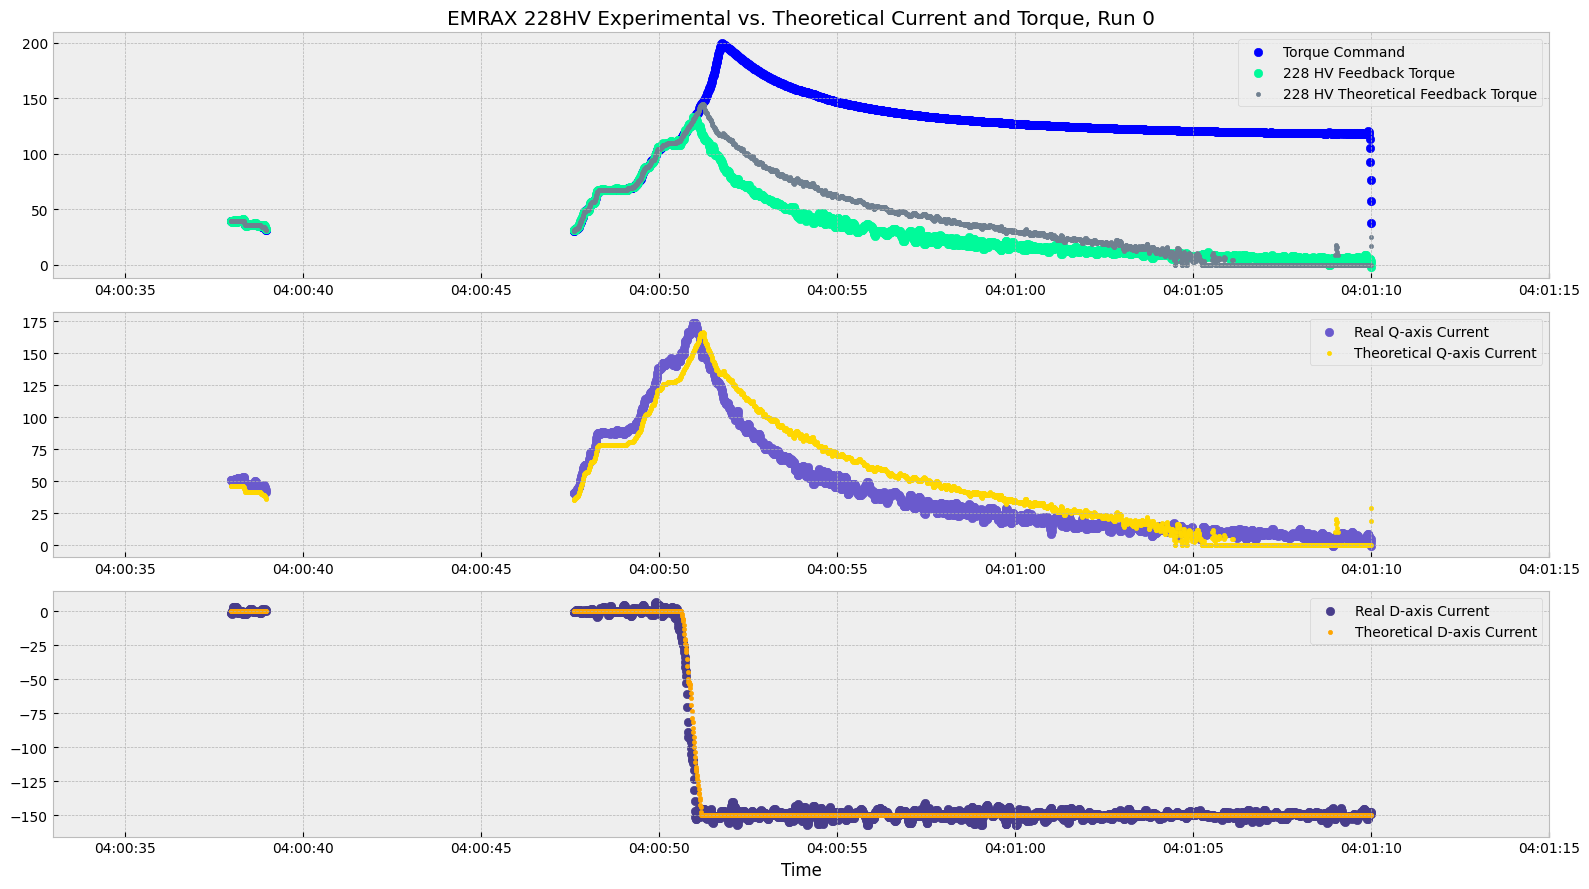

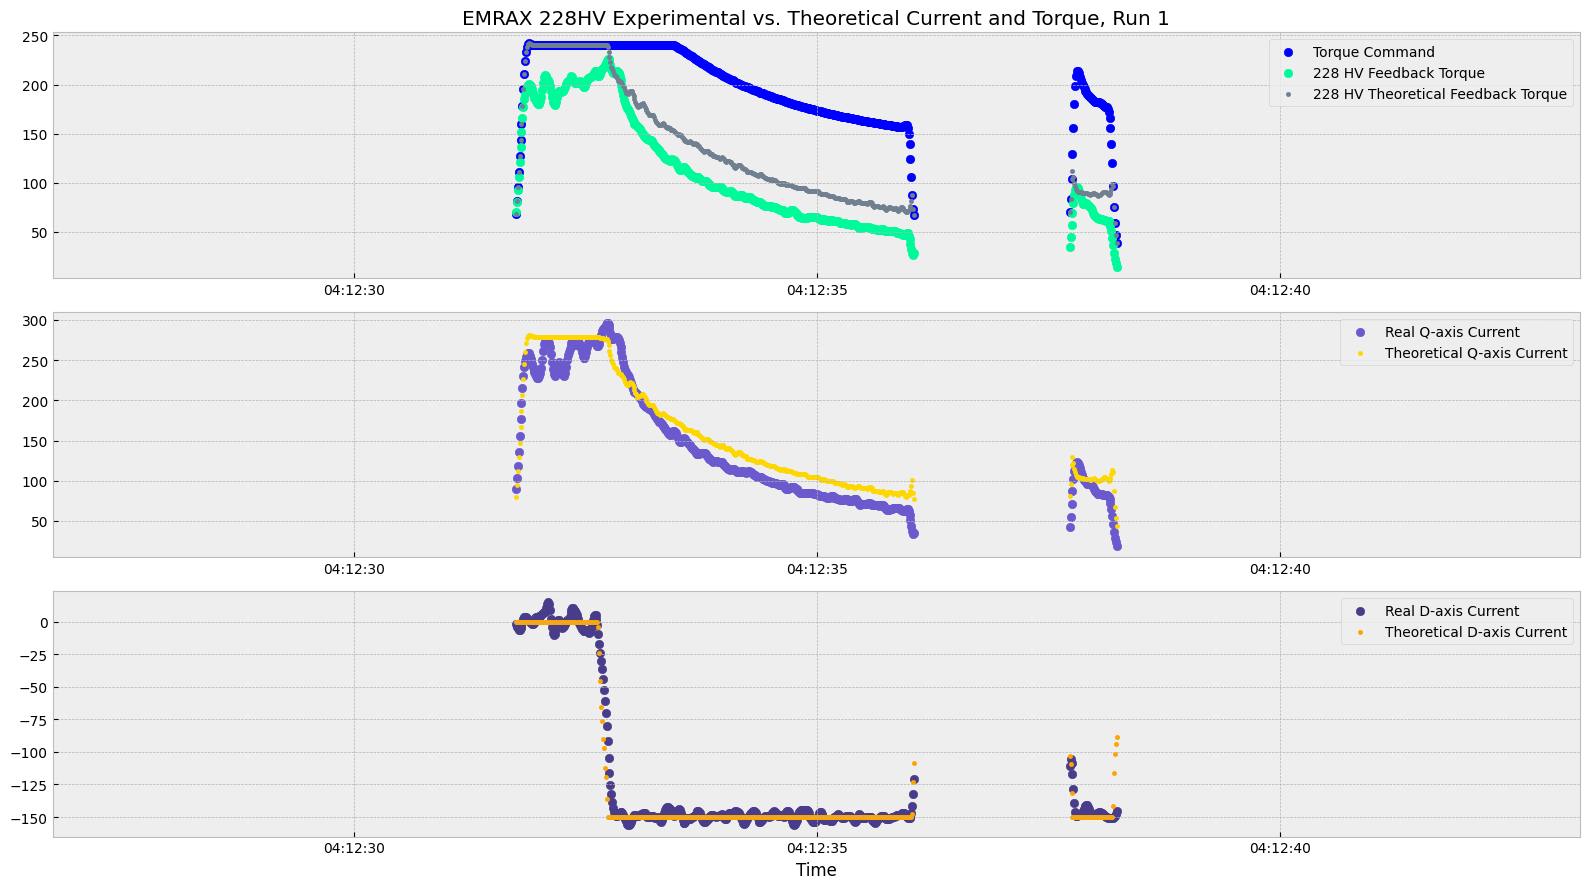

In [ ]:
runs_dfs = []
car2df['groups'] = (
    car2df.index.to_series().diff().dt.seconds > 20).cumsum()

for ct, data in car2df.groupby('groups'):
    runs_dfs.append(data)
for index,df in enumerate(runs_dfs):
    fig,(ax,ax1,ax2) = plt.subplots(3,1,figsize=(16,9))
    ax.title.set_text(f"EMRAX 228HV Experimental vs. Theoretical Current and Torque, Run {index}")

    earliest_timestamp = df.index.min()
    last_timestamp = df.index.max()
    runoffset = pd.tseries.offsets.DateOffset(seconds=5)
    centertime = df['filtD2_Torque_Feedback'].idxmax()
    xlims = (earliest_timestamp-runoffset,last_timestamp+runoffset)
    # Torque command
    ax.scatter(df.index, df['filtD1_Commanded_Torque'],
                    marker='o', label="Torque Command", c='blue')
    #Real torque feedback``
    ax.scatter(df.index, df['filtD2_Torque_Feedback'],
                    marker='o', label="228 HV Feedback Torque", c='mediumspringgreen')

    ax.scatter(df.index, df['t_t'],
                    marker='.', label="228 HV Theoretical Feedback Torque",c='slategrey')
    # Real Q-axis current
    ax1.scatter(df.index, df['filtD4_Iq'],
                    marker='o', label="Real Q-axis Current",c='slateblue')

    ax1.scatter(df.index, df['iq_t'],
                    marker='.', label="Theoretical Q-axis Current",color='gold')

    ax2.scatter(df.index, df['filtD3_Id'],
                    marker='o', label="Real D-axis Current",c='darkslateblue')
    # plt.xlim(xlims)

    ax2.scatter(df.index, df['id_t'],
                    marker='.', label="Theoretical D-axis Current",color='orange')

    for axis in plt.gcf().get_axes():
        axis.legend()
        axis.grid(visible=True)
        axis.set_xlim(xlims)
    ax2.set_xlabel("Time")

    plt.tight_layout()
    plt.show()

In [ ]:
# fig,(ax,ax1,ax2) = plt.subplots(3,1,figsize=(16,9))
# ax.title.set_text("EMRAX 228MV Experimental vs. Theoretical Current and Torque")


# runoffset = pd.tseries.offsets.DateOffset(seconds=30)
# centertime = car3df['filtD2_Torque_Feedback'].idxmax()
# # Torque command
# ax.scatter(car3df.index, car3df['filtD1_Commanded_Torque'],
#                 marker='o', label="Torque Command", c='blue')
# #Real torque feedback``
# ax.scatter(car3df.index, car3df['filtD2_Torque_Feedback'],
#                 marker='o', label="228MV Feedback Torque", c='mediumspringgreen')

# ax.scatter(car3df.index, car3df['228MVt_t'],
#                 marker='o', label="228MV Theoretical Feedback Torque",c='slategrey')
# # Real Q-axis current
# ax1.scatter(car3df.index, car3df['filtD4_Iq'],
#                 marker='o', label="Real Q-axis Current",c='slateblue')

# ax1.scatter(car3df.index, car3df['228MViq_t'],
#                 marker='o', label="Theoretical Q-axis Current",color='gold')

# ax2.scatter(car3df.index, car3df['filtD3_Id'],
#                 marker='o', label="Real D-axis Current",c='darkslateblue')
# # plt.xlim(xlims)

# ax2.scatter(car3df.index, car3df['228MVid_t'],
#                 marker='o', label="Theoretical D-axis Current",color='orange')
# ylabels = ["Torque (Nm)","Current (Apk)","Current(Apk)"]
# for index,axis in enumerate(plt.gcf().get_axes()):
#     axis.legend()
#     axis.grid(visible=True)
#     axis.set_ylabel(ylabels[index])
    
# ax2.set_xlabel("RPM")
# plt.tight_layout()

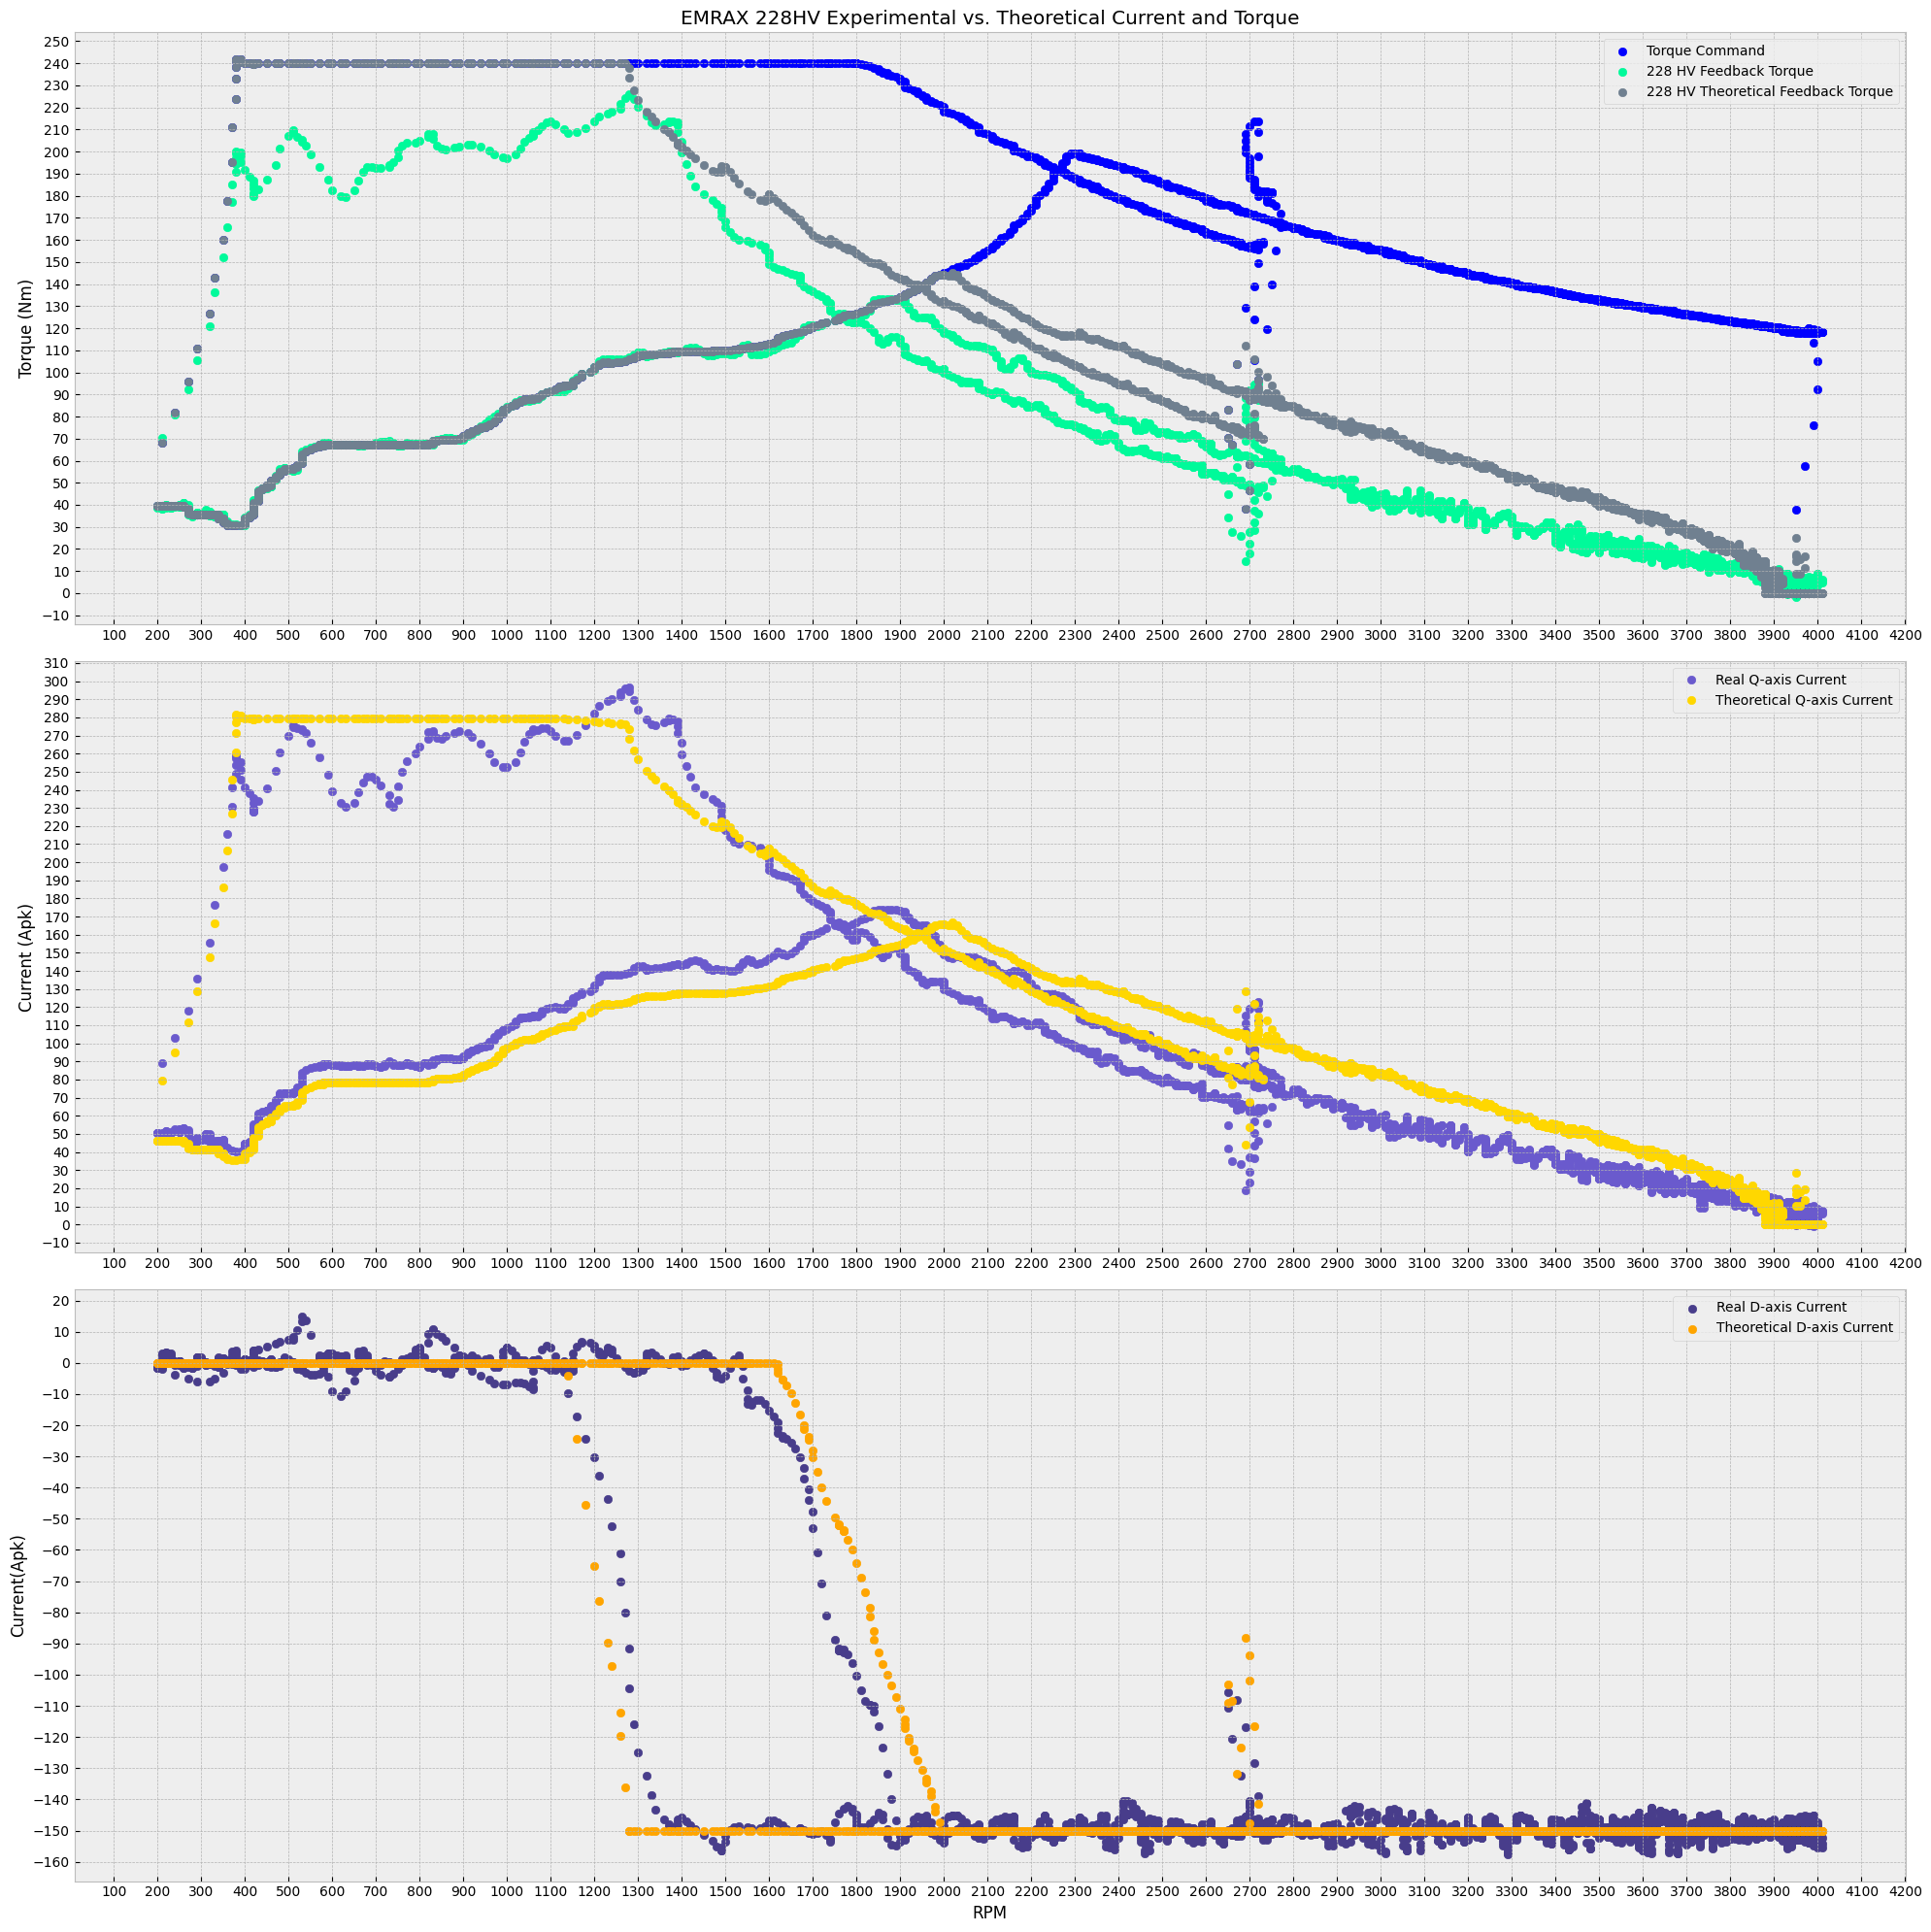

In [ ]:
fig,(ax,ax1,ax2) = plt.subplots(3,1,figsize=(20,20))
ax.title.set_text("EMRAX 228HV Experimental vs. Theoretical Current and Torque")


runoffset = pd.tseries.offsets.DateOffset(seconds=30)
centertime = car2df['filtD2_Torque_Feedback'].idxmax()
# Torque command
ax.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD1_Commanded_Torque'],
                marker='o', label="Torque Command", c='blue')
#Real torque feedback``
ax.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD2_Torque_Feedback'],
                marker='o', label="228 HV Feedback Torque", c='mediumspringgreen')

ax.scatter(car2df['filtD2_Motor_Speed'], car2df['t_t'],
                marker='o', label="228 HV Theoretical Feedback Torque",c='slategrey')
# Real Q-axis current
ax1.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD4_Iq'],
                marker='o', label="Real Q-axis Current",c='slateblue')

ax1.scatter(car2df['filtD2_Motor_Speed'], car2df['iq_t'],
                marker='o', label="Theoretical Q-axis Current",color='gold')

ax2.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD3_Id'],
                marker='o', label="Real D-axis Current",c='darkslateblue')
# plt.xlim(xlims)

ax2.scatter(car2df['filtD2_Motor_Speed'], car2df['id_t'],
                marker='o', label="Theoretical D-axis Current",color='orange')
ylabels = ["Torque (Nm)","Current (Apk)","Current(Apk)"]
for index,axis in enumerate(plt.gcf().get_axes()):
    axis.legend()
    axis.grid(visible=True)
    axis.set_ylabel(ylabels[index])
    axis.grid(visible=True)
    axis.xaxis.grid(True,which="minor")
    axis.xaxis.set_major_locator(MultipleLocator(100))
    axis.xaxis.set_major_formatter('{x:.0f}')
    axis.yaxis.set_major_locator(MultipleLocator(10))

ax2.set_xlabel("RPM")
plt.tight_layout()
plt.show()
# plt.ylabel("Nm, Amps")
# plt.xlabel("RPM")

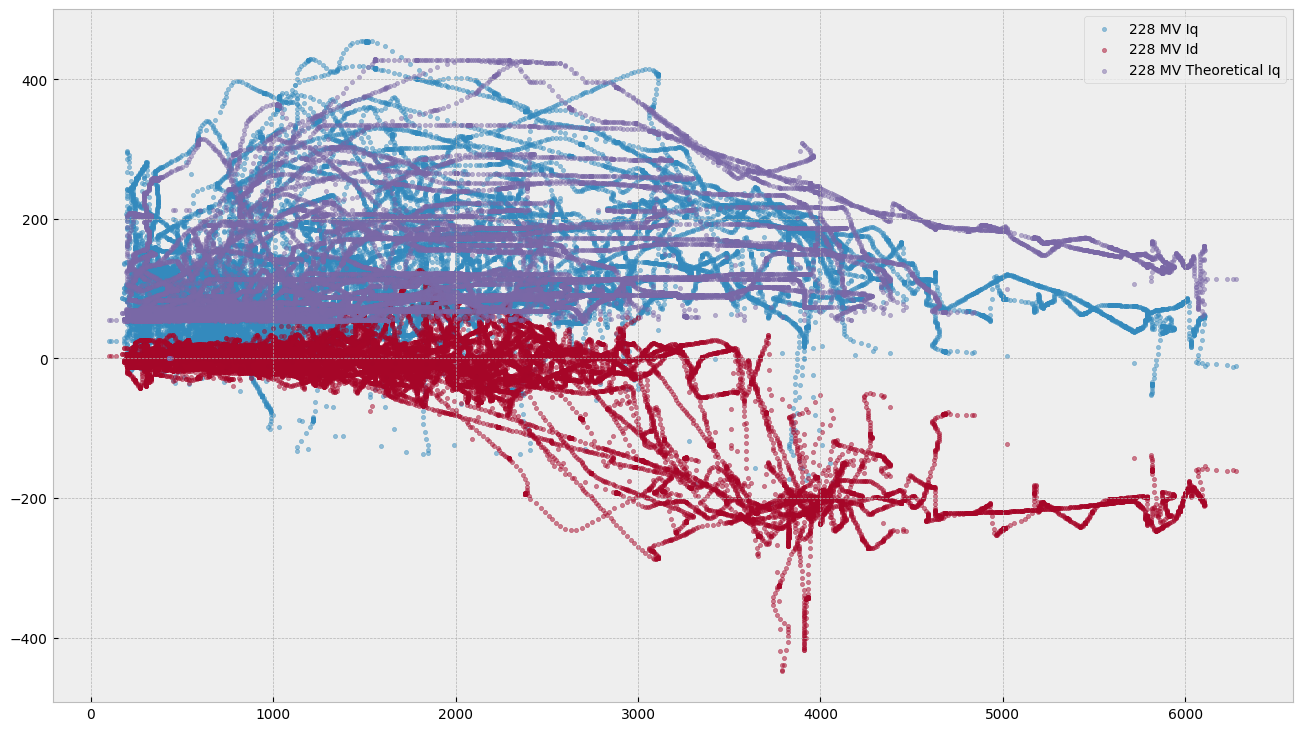

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
runoffset = pd.tseries.offsets.DateOffset(seconds=30)
centertime = car1df['filtD2_Torque_Feedback'].idxmax()
xlims = (centertime-runoffset,centertime+runoffset)
# ax.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD2_Torque_Feedback'],
#                 marker='.', label="228 MV Feedback Torque", c='cornflowerblue', alpha=0.9)
# ax.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD1_Commanded_Torque'],
#                 marker='.', label="228 MV Command Torque",  alpha=0.9)
ax.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD4_Iq'],
                marker='.', label="228 MV Iq", alpha=0.5)
ax.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD3_Id'],
                marker='.', label="228 MV Id", alpha=0.5)
# plt.xlim(xlims)
# ax.scatter(car1df['filtD2_Motor_Speed'], car1df['t_t'],
#                 marker='.', label="228 MV Theoretical Feedback Torque", alpha=0.5)
ax.scatter(car1df['filtD2_Motor_Speed'], car1df['iq_t'],
                marker='.', label="228 MV Theoretical Iq", alpha=0.5)
# ax.scatter(car1df['filtD2_Motor_Speed'], car1df['id_t'],
#                 marker='.', label="228 MV Theoretical Id", alpha=0.5)
plt.legend()

In [ ]:
# Attempt to correct start of torque curves

dfcar1 = car1df.set_index('filtD2_Motor_Speed',inplace=False)
dfcar2 = car2df.set_index('filtD2_Motor_Speed',inplace=False)

dfcar1.dropna(axis=0,inplace=True)
for col in list(dfcar1):
    dfcar1 = dfcar1.loc[dfcar1.groupby(dfcar1.index)[col].idxmax()]
dfcar2.dropna(axis=0,inplace=True)

for col in list(dfcar2):
    dfcar2 = dfcar2.loc[dfcar2.groupby(dfcar2.index)[col].idxmax()]

car1torquemax = dfcar1['filtD2_Torque_Feedback'].max()
car1torquemaxindex = dfcar1['filtD2_Torque_Feedback'].idxmax()

car2torquemax = dfcar2['filtD2_Torque_Feedback'].max()
car2torquemaxindex = dfcar2['filtD2_Torque_Feedback'].idxmax()

dfcar1['filtD2_Torque_Feedback'].loc[:car1torquemaxindex] = car1torquemax
dfcar2['filtD2_Torque_Feedback'].loc[:car2torquemaxindex] = car2torquemax

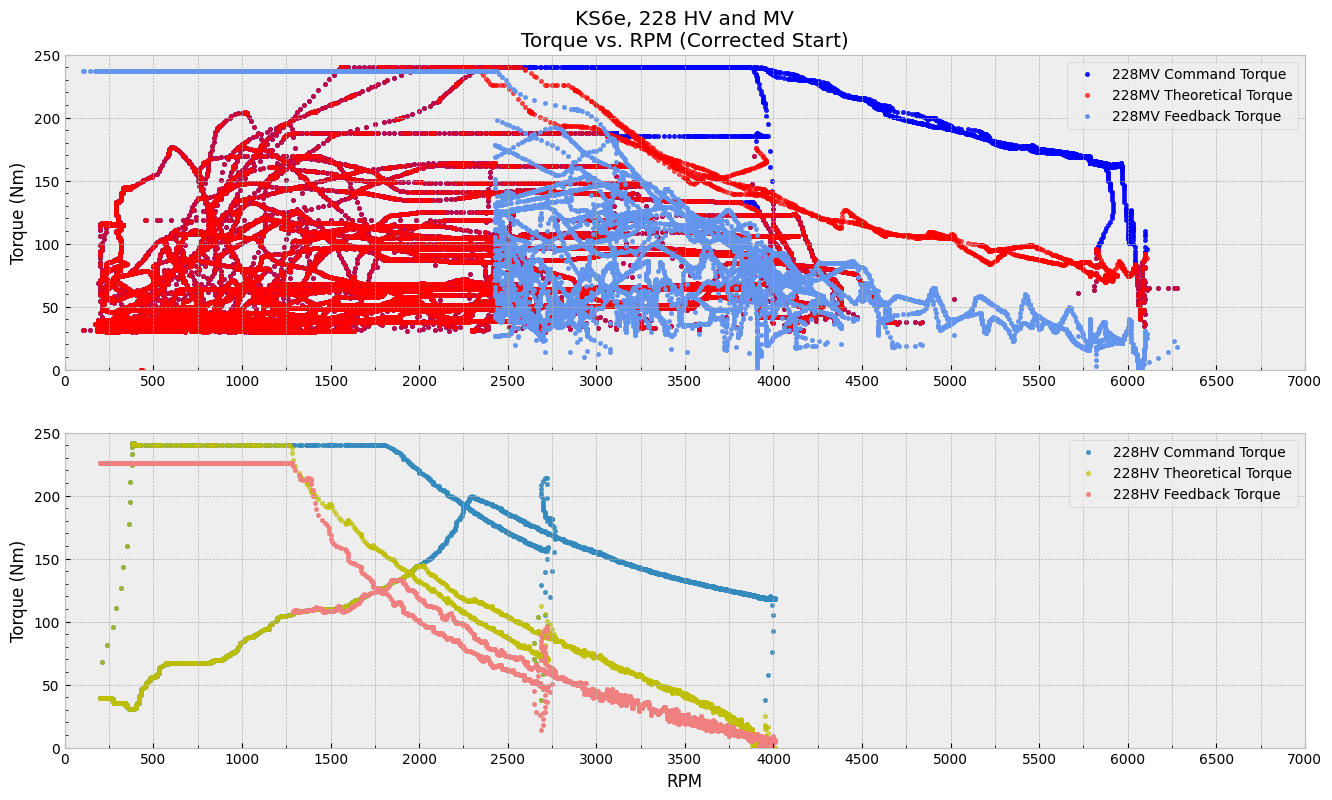

In [ ]:
fig, (ax,ax1) = plt.subplots(2,1,figsize=(16,9))

ax.scatter(dfcar1.index, dfcar1['filtD1_Commanded_Torque'],
                marker='.', label="228MV Command Torque", c='blue', alpha=0.9)
ax.scatter(dfcar1.index, dfcar1['t_t'],
                marker='.', label="228MV Theoretical Torque",c='r', alpha=0.7)
ax.scatter(dfcar1.index, dfcar1['filtD2_Torque_Feedback'],
                marker='.', label="228MV Feedback Torque", c='cornflowerblue')


# ax.scatter(dfcar1.index, dfcar1['filtD4_Iq'],
#                 marker='.', label="228 MV Iq", alpha=0.5)
ax1.scatter(dfcar2.index, dfcar2['filtD1_Commanded_Torque'],
                marker='.', label="228HV Command Torque", alpha=0.9)
ax1.scatter(dfcar2.index, dfcar2['t_t'],
                marker='.', label="228HV Theoretical Torque",c='y', alpha=0.7)
ax1.scatter(dfcar2.index, dfcar2['filtD2_Torque_Feedback'],
                marker='.', label="228HV Feedback Torque",c='lightcoral')

# ax.scatter(dfcar2['filtD2_Motor_Speed'], dfcar2['filtD4_Iq'],
#                 marker='.', label="228 HV Iq",  alpha=0.5)

ylabels = ["Torque (Nm)","Torque (Nm)"]
for index,axis in enumerate(plt.gcf().get_axes()):
    axis.legend()
    axis.set_ylabel(ylabels[index])
    
    axis.grid(visible=True)
    axis.xaxis.grid(True,which="minor")
    axis.xaxis.set_major_locator(MultipleLocator(500))
    axis.xaxis.set_major_formatter('{x:.0f}')

# For the minor ticks, use no labels; default NullFormatter.
    axis.xaxis.set_minor_locator(MultipleLocator(250))
    axis.yaxis.set_minor_locator(MultipleLocator(10))

    axis.set_ylim((0,250))
    axis.set_xlim((0,7000))
ax.title.set_text("KS6e, 228 HV and MV\nTorque vs. RPM (Corrected Start)")


plt.xlabel("RPM")
plt.ylabel("Torque (Nm)")
plt.legend()

In [ ]:
# Calculate error at max
for df in df_list[:2]:
    realmax = df['filtD2_Torque_Feedback'].max()
    theorymax = df['t_t'].max()
    print(f"Real Torque: {realmax} Theoretical Torque: {theorymax}")
    print(f"Difference: {realmax-theorymax}")

Real Torque: 237.1954473769121 Theoretical Torque: 240.33074483113163
Difference: -3.1352974542195113
Real Torque: 225.79382913300455 Theoretical Torque: 241.81221378880906
Difference: -16.01838465580451
